In [2]:
from __future__ import division
from importlib import reload
from modules import * 
import pickle
import csv
fig_savedir = '../data/figures/'

## TO do list in experiment.py 

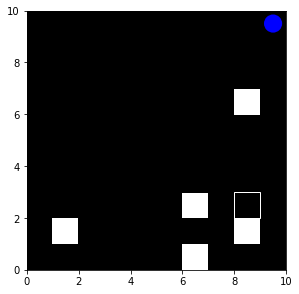

In [29]:
reload(eu)
grid_params = {
    'y_height':     10, 
    'x_width':      10,
    'walls':        False,
    'rho':          0.05,
    'maze_type':    'none',
    'port_shift':   'none'
    
}

#make environment
maze = eu.gridworld(grid_params, pen = -0.01)
gp.plot_env(maze)

In [30]:
def reset_agt(agent_params):
        ## some stupid reward placement shit -- replace later
    if agent_params['load_model'] == True:
        if agent_params['rwd_placement'] == 'training_loc':
            maze.set_rwd([(int(grid_params['x_width']/2), int(grid_params['y_height']/2))])
        if agent_params['rwd_placement'] == 'moved_loc':
            maze.set_rwd([(int(3*grid_params['x_width']/4)),int(grid_params['y_height']/4)])
    else:
        maze.set_rwd([(int(grid_params['x_width']/2),int(grid_params['y_height']/2))])
        
    # make agent 
    agent_params = expt.gen_input(maze, agent_params)
    MF,opt = ac.make_agent(agent_params, freeze=False)

    if agent_params['use_EC']:
        #agent_params['cachelim'] = int(0.5*np.prod(maze.grid.shape))
        agent_params['EC'] = ec.ep_mem(MF,agent_params['cachelim'])
    
    run_dict = {}
    run_dict = {
        'NUM_EVENTS':   300,
        'NUM_TRIALS':   1000,
        'environment':  maze,
        'agent':        MF,
        'optimizer':    opt,
        'agt_param':    agent_params
    }
    
    return run_dict

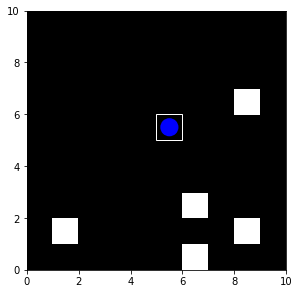

In [38]:
agent_params = {
        'load_model':   False,
        'load_dir':     '../data/outputs/gridworld/openfield{}{}.pt'.format(grid_params['x_width'],grid_params['y_height']),
        'rwd_placement':'training_loc',
        'action_dims':  len(maze.actionlist),
        'lin_dims':     500,
        'batch_size':   1,
        'gamma':        0.98, #discount factor
        'eta':          5e-4,
        'temperature':  1,
        'use_EC':       True,
        'cachelim':     300, # memory limit should be ~75% of #actions x #states
        'state_type':   'conv'
    }
run_dict = reset_agt(agent_params)
reload(gp)
gp.plot_env(maze)

In [39]:
reload(expt)
run_dict = reset_agt(agent_params)
#expt.run_full_trials(run_dict, pen = -0.0)
#expt.run_truncated_trials(run_dict, pen=-0.01, use_EC=False)
expt.run(run_dict) ## by default runs truncated trials with MF only

[16:48:44]  Trial 1 TotRew = 0.5599999999999998 (0.048s)
[16:48:52]  Trial 101 TotRew = 0.48999999999999977 (7.738s)
[16:48:57]  Trial 201 TotRew = 0.86 (4.947s)
[16:49:01]  Trial 301 TotRew = 0.85 (4.192s)
[16:49:03]  Trial 401 TotRew = 0.91 (2.335s)
[16:49:06]  Trial 501 TotRew = 0.83 (2.252s)
[16:49:07]  Trial 601 TotRew = 0.6699999999999999 (1.825s)
[16:49:09]  Trial 701 TotRew = 0.98 (1.777s)
[16:49:11]  Trial 801 TotRew = 0.8099999999999999 (1.861s)
[16:49:13]  Trial 901 TotRew = 0.84 (2.178s)
[16:49:15]  Trial 1000 TotRew = 0.94 (1.550s)


In [40]:
policy_loss = run_dict['total_loss'][0]
value_loss = run_dict['total_loss'][1]
tot_reward = run_dict['total_reward']
trial_length = run_dict['trial_length']

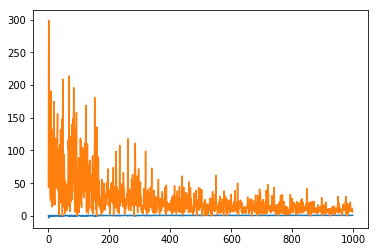

In [42]:
plt.plot(tot_reward)
plt.plot(trial_length)

#pick = [tot_reward, policy_loss, value_loss, trial_length]
#pickle.dump(pick, open("pickles/initial_training.p", "wb"))

In [43]:
ac.torch.save(run_dict['agent'],agent_params['load_dir'])

In [ ]:
vv, pp = ac.snapshot(agent=run_dict['agent'], maze =run_dict['environment'])

gp.plot_polmap(run_dict['environment'], pp)
gp.plot_valmap(run_dict['environment'], vv, p_range = [0,.25])

In [ ]:
ttt = ac.mem_snapshot(run_dict['environment'], agent_params['EC'], trial_timestamp=1, decay=100)
gp.plot_polmap(run_dict['environment'],ttt)

In [ ]:
key_ = 0 
for k, v in agent_params['EC'].cache_list.items():
    if v[2] == (10,10):
        key_ = k
        print(agent_params['EC'].cache_list[key_][0])

plt.figure()
plt.bar(np.arange(6), agent_params['EC'].recall_mem(key_, 26))
plt.ylim([0,1])

In [ ]:
fig,ax = plt.subplots(2,1, sharex=True)
ax[0].plot(policy_loss)
ax[0].axvline(x = run_dict['NUM_TRIALS'],color='k', linestyle=':', alpha=0.5)
ax[0].set_ylabel('Policy Loss')
ax[1].plot(value_loss)
ax[1].axvline(x = run_dict['NUM_TRIALS'],color='k', linestyle=':', alpha=0.5)
ax[1].set_ylabel('Value Loss')

#ax[0].arrow(2000, max(policy_loss), 0, -600, head_width=50, head_length=100, fc='k', ec='k')
#ax[1].arrow(2000, max(value_loss), 0, -600, head_width=50, head_length=100, fc='k', ec='k')

#plt.savefig('../data/figures/loss_after_trunc_training.svg', format='svg')
plt.show()
plt.close()

In [ ]:
x = -1
print(value_loss[x])
print(policy_loss[x])

In [ ]:
vv, pp = ac.snapshot(agent=run_dict['agent'], maze =run_dict['environment'])
reload(gp)
gp.plot_polmap(run_dict['environment'], pp)
gp.plot_valmap(run_dict['environment'], vv, p_range=[0,1.5])

In [ ]:
def test_pvals(p, **kwargs):
    envelope = kwargs.get('envelope', 50)
    mfc      = kwargs.get('conf_score', 1)
    return mfc*np.round(1 / np.cosh(p / envelope), 8)

In [ ]:

a = np.linspace(1,200, 100)#np.sort(np.random.randint(1,100,10))
b = 10*np.arange(10)+5
for i in b:
    a_p = test_pvals(a, envelope=i)
    plt.plot(a, a_p, '-', label=f'{i}')
plt.legend(loc=0)
#ax[1].plot(a_p)


In [ ]:
EC = agent_params['EC']

In [ ]:
import time
meas_time = time.time()
x = np.asarray(list(agent_params['EC'].cache_list.keys()))
#x = np.asarray([*agent_params['EC'].cache_list.keys()])
print(time.time() - meas_time)

In [ ]:
reload(ec)
test_case = x[0]+ 0.3*(np.random.randn(500))
key, index, sim = EC.cosine_sim(test_case)
print(key[0:10], index, sim)
EC.recall_mem(key, timestep=1)


In [ ]:
ac.torch.save(run_dict['agent'],agent_params['load_dir'])